# Filtering Investigation

This notebook investigates various averaging (filter) approaches for dealing with the raw data from the bluetooth speed and cadence sensors.

This will be done by first defining a test "true" speed and cadence profile. From this "true" profile, quantized data that simulates the bluetooth sensors (one "tick" per revolution) will be created.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.optimize
import random
import numba


matplotlib.rcParams['figure.figsize'] = (18, 16)

In [2]:
ROLLING_LENGTH = 2096.
DT = 0.25


# Generate Speed and Cadence Data

We'll create some functions for generating speed and cadence data.

In [3]:
def generate_segment(t0, time, start_speed, end_speed):
    data = pd.DataFrame({
        "t": pd.Series(np.arange(t0, t0 + time, step=DT, dtype=np.float))
    })
    data = data.assign(
        V=np.linspace(start_speed, end_speed, num=len(data))
    )
    data = data.assign(
        V=[max(v, 0) for v in data.V]
    )
    return data


def generate_cadence(omega: pd.Series) -> (np.ndarray, np.ndarray, np.ndarray):
    #  Take the number of teeth from a Trek Emonda SLR 9
    rear = [11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 28]
    front = [50, 34]
    target_cadence = 80 / 60  # revs/sec
    cadence_range = 30 / 60
    cur_i_front = 1
    cur_i_rear = 5
    
    front_gear = np.zeros(len(omega))
    rear_gear = np.zeros(len(omega))
    crank_speed = np.zeros(len(omega))
    
    for i, om in np.ndenumerate(omega.values):  # units: revs/s
        front_gear[i] = cur_i_front
        rear_gear[i] = cur_i_rear
        crank_speed[i] = om * rear[cur_i_rear] / front[cur_i_front]
        # Adjust the front chain ring position, if needed
        if cur_i_rear < (len(rear) / 2 - 2) and cur_i_front == 1:
            cur_i_front = 0
        elif cur_i_rear > (len(rear) / 2 + 2) and cur_i_front == 0:
            cur_i_front = 1
        else:
            cadence_deviation = crank_speed[i] - target_cadence
            shift_probability = (cadence_deviation / cadence_range) ** 2
            if random.random() < shift_probability:
                cur_i_rear = cur_i_rear - 1 if cadence_deviation > 0 else cur_i_rear + 1
                cur_i_rear = min(len(rear) - 1, cur_i_rear)
                cur_i_rear = max(0, cur_i_rear)
    
    return crank_speed, front_gear, rear_gear


def generate_simulation():
    n_segments = random.randint(5, 10)
    speed = 0
    time = 0
    data = pd.DataFrame()
    for i in range(n_segments):
        if random.choice([True, False]) or n_segments == 0:
            #  Change the speed for this segment
            new_speed = random.uniform(0, 40)
            # limit the acceleration to 0.5 m/s (note, speed is in km/h)
            segment_time = abs(new_speed - speed) / 0.5 * 3.6 * random.uniform(0, 1)
            seg = generate_segment(time, segment_time, speed, new_speed)
            speed = new_speed
        else:
            #  Keep the speed constant for this segment
            segment_time = random.uniform(10, 200)
            seg = generate_segment(time, segment_time, speed, speed)
        data = pd.concat([data, seg])
        time = time + segment_time
    
    data.reset_index()
    
    #  add a columns for wheel speed, wheel rotations and measured wheel rotations
    data = data.assign(
        omega=[V * 1e+6 / ROLLING_LENGTH / 3600. for V in data.V]  # revs/s
    )
    data = data.assign(
        N=np.insert(integrate.cumtrapz(data.omega, data.t), 0, 0)
    )
    data = data.assign(
        N_meas=[np.floor(N) for N in data.N]
    )
    crank_speed, front_gear, rear_gear = generate_cadence(data.omega)
    data["crank_speed"] = crank_speed
    data["front_gear"] = front_gear
    data["rear_gear"] = rear_gear
    data = data.assign(
        crank_rots=np.insert(integrate.cumtrapz(data.crank_speed, data.t), 0, 0)
    )
    data = data.assign(
        crank_meas=[np.float(cr) for cr in data.crank_rots]
    )
    return data

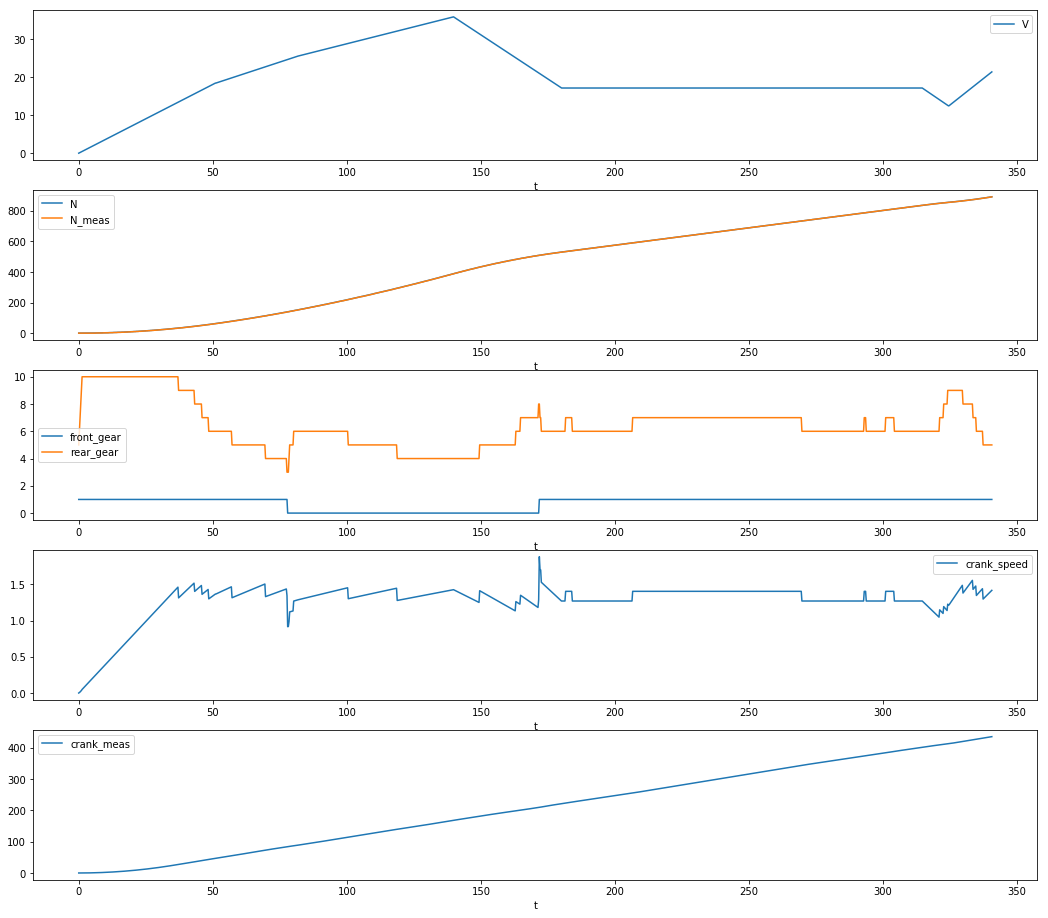

In [4]:
matplotlib.rcParams['figure.figsize'] = (18, 16)

random.seed(23456)  # make this example reproducible
sim_data1 = generate_simulation()
fig, ax = plt.subplots(nrows=5, facecolor="white")
sim_data1.plot(ax=ax[0], x='t', y='V')
sim_data1.plot(ax=ax[1], x='t', y='N')
sim_data1.plot(ax=ax[1], x='t', y='N_meas')
sim_data1.plot(ax=ax[2], x='t', y="front_gear")
sim_data1.plot(ax=ax[2], x='t', y='rear_gear')
sim_data1.plot(ax=ax[3], x='t', y='crank_speed')
sim_data1.plot(ax=ax[4], x='t', y='crank_meas')

Now that we have a way of randomly generating profiles, we'll create a bunch of them. We'll use these to test the filtering.

In [5]:
random.seed(23456)  # make this example reproducible

NUM_SIM = 50

sim_data = [generate_simulation() for i in range(NUM_SIM)]


The plot below shows a few of the profiles generated.

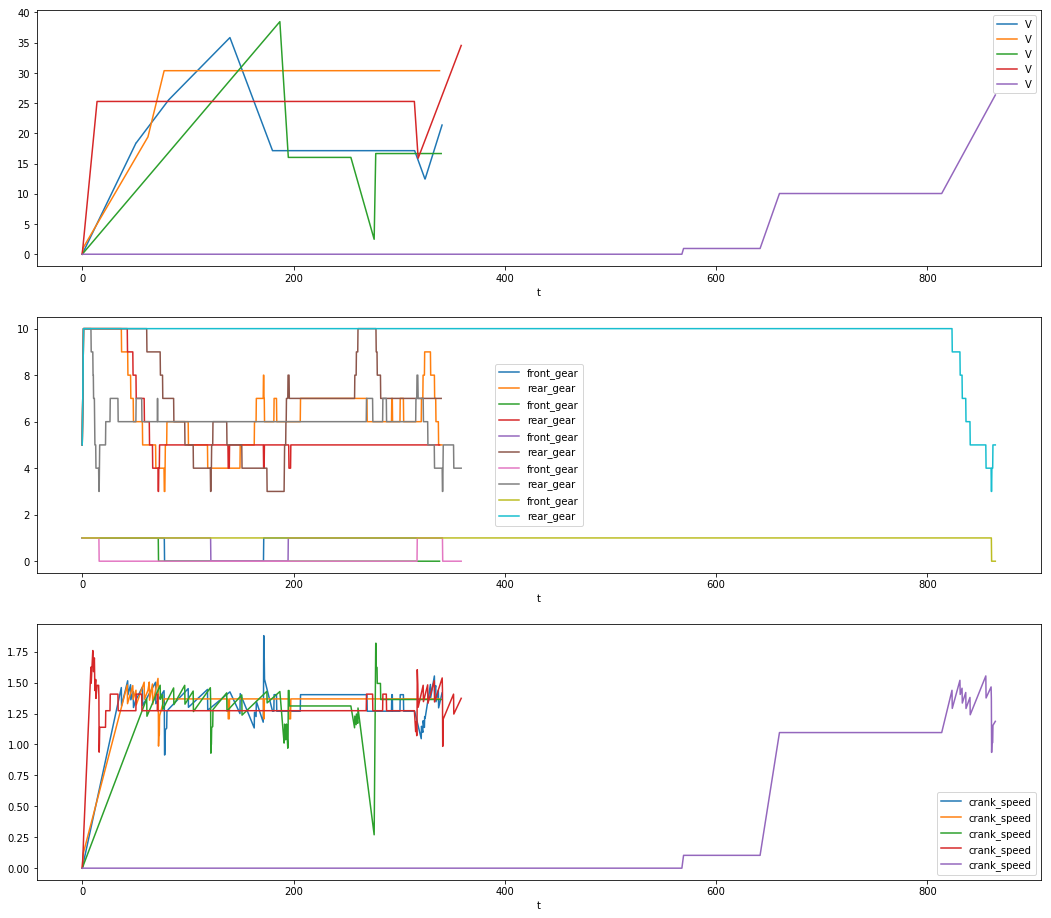

In [6]:
fig, ax = plt.subplots(nrows=3, facecolor="white")

for i, sd in enumerate(sim_data):
    if i % 10 == 0:
        sd.plot(ax=ax[0], x='t', y="V")
        sd.plot(ax=ax[1], x='t', y="front_gear")
        sd.plot(ax=ax[1], x='t', y='rear_gear')
        sd.plot(ax=ax[2], x='t', y='crank_speed')

# Approach Number One

In this approach, each time we get a new reading of crank- or wheel-rotation, we'll calculate the instantaneous speed by taking the difference between this reading and the previous one. This will get added to a list. This list will then be interrogated and all readings that are older than a threshold time (say, 3 seconds) will be discarded. Then, the contents of the list will be averaged.

In [7]:
def filter_count(data, time_col, rev_col, averaging_time=3.):
    rev_readings = []
    prev_t = -1.
    prev_rev = -1.
    for i, (t, r) in enumerate(zip(data[time_col], data[rev_col])):
        if prev_rev == -1. or prev_rev != r:
            rev_readings.append((t, (r - prev_rev) / (t - prev_t)))
            prev_t = t
            prev_rev = r
    
    res = np.zeros((len(rev_readings), 2), dtype=np.float64)
    reading_list = []
    
    for i, (t, v) in enumerate(rev_readings):
        new_reading_list = []
        for ti, vi in reading_list:
            if ti >= t - averaging_time:
                new_reading_list.append((ti, vi))
        new_reading_list.append((t, v))
        reading_list = new_reading_list
        res[i, 0] = t
        res[i, 1] = sum([v for t, v in reading_list]) / len(reading_list)
    return res

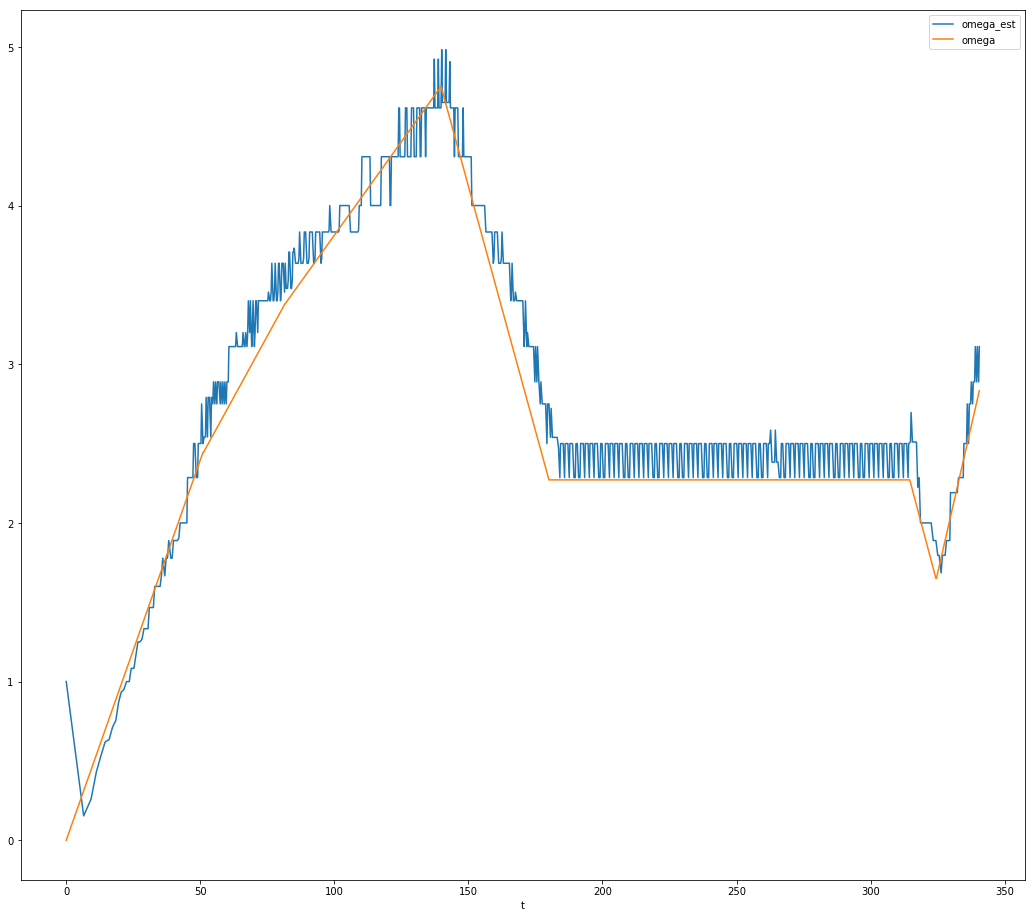

In [8]:
res = filter_count(sim_data[0], "t", "N_meas", 3.)
res = pd.DataFrame({
    "t": res[:, 0],
    "omega_est": res[:, 1],
})

fig, ax = plt.subplots(nrows=1, facecolor="white")
res.plot(ax=ax, x='t', y="omega_est")
sim_data[0].plot(ax=ax, x='t', y="omega")

There is both some bias in this estimator, plus a certain amount of noise. We can try to do better.

# Approach Number Two

In [10]:
class SpeedSegment:
    def __init__(self, t_start: float, n_start: int):
        self.t_start = t_start
        self.t_end = None
        self.n_start = n_start
        self.n_end = None
    
    def set_finish(self, t_end, n_end):
        self.t_end = t_end
        self.n_end = n_end
    
    @property
    def t_total(self):
        return self.t_end - self.t_start
    
    @property
    def rot_speed(self):
        return (self.n_end - self.n_start) / (self.t_end - self.t_start)
    
    def time_within_window(self, window_start, window_end):
        if self.rot_speed is None:
            return 0.  # This segment isn't finished, so there isn't a speed
        return min(window_end, self.t_end) - max(window_start, self.t_start) 


def filter_improved(data, time_col, rev_col, averaging_time=3.):
    res = np.zeros((data.size - 2, 2), dtype=np.float64)
    speed_segments = []
    cur_speed_segment = SpeedSegment(data[time_col].iloc[0], data[rev_col].iloc[0])
    
    for i, (t, r) in enumerate(zip(data[time_col], data[rev_col])):
        if cur_speed_segment.n_start != r:
            cur_speed_segment.set_finish(t, r)
            speed_segments.append(cur_speed_segment)
            cur_speed_segment = SpeedSegment(t, r)
        
        active_speed_segments = []
        for li in speed_segments:
            if li.t_end >= t - averaging_time:
                active_speed_segments.append(li)
        speed_segments = active_speed_segments
        
        # the amount of time in the averaging window for all the speed segments
        t_window = sum([s.time_within_window(t - averaging_time, t) for s in speed_segments])
        if t_window > 0:
            speed_estimate = sum([s.time_within_window(t - averaging_time, t) * s.rot_speed
                                  for s in speed_segments if s.rot_speed is not None]) / t_window
        else:
            speed_estimate = 0.
        
        res[i, 0] = t
        res[i, 1] = speed_estimate
    return res

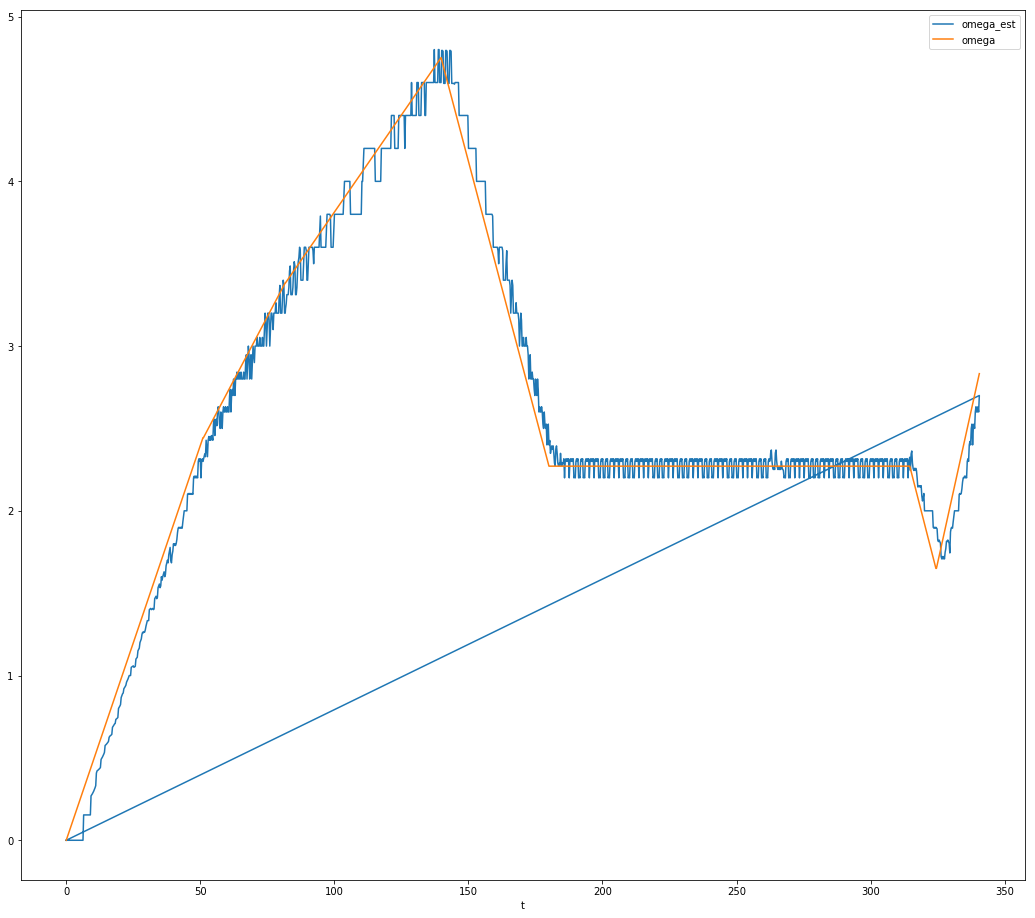

In [11]:
res = filter_improved(sim_data[0], "t", "N_meas", 5.)
res = pd.DataFrame({
    "t": res[:, 0],
    "omega_est": res[:, 1],
})

fig, ax = plt.subplots(nrows=1, facecolor="white")
res.plot(ax=ax, x='t', y="omega_est")
sim_data[0].plot(ax=ax, x='t', y="omega")

With this approach, there is some lag, as expected with most filter, but in the steady-state regions, the results are fairly good. This approach will be used in the actual implementaiton.